In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2023-08-04 11:13:23.666930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


# Define functions to simulate dynamics

In [3]:
from scipy.integrate import solve_ivp

def fio_rect(x):
#     x[x<0] = 0
#     return x
    return np.fmax(x,0)

def dynamics_system(y,inp_ff,Wrec,\
                    gamma_rec,gamma_ff,N,tau):
#     argE = gamma_rec * np.dot(Wrec[:N],y) + gamma_ff * inp_ff[0]
#     argI = gamma_rec * np.dot(Wrec[N:],y) + gamma_ff * inp_ff[1]
#     return 1./tau*( -y + fio_rect(np.concatenate([argE,argI])))
    arg = gamma_rec * np.dot(Wrec,y) + gamma_ff * inp_ff.flatten()
    return 1./tau*( -y + fio_rect(arg))

def integrate(y0,inp,dt,Nt,gamma_rec=1.02):
    y = y0
    for t_idx in range(Nt):
        out = dynamics_system(y,inp,W4to4,gamma_rec,1.0,N4*N4,1.0)
        dy = out
        y = y + dt*dy
    return np.array([y[:N4**2].reshape((N4,N4)),y[N4**2:].reshape((N4,N4))])
#     def ode_fun(t,y):
#         return dynamics_system(y,inp,W4to4,gamma_rec,1.0,N4*N4,1.0)
#     sol = solve_ivp(ode_fun,[0,dt*Nt],y0,method='RK23',first_step=dt)
#     return np.array([sol.y[:N4**2,-1].reshape((N4,N4)),sol.y[N4**2:,-1].reshape((N4,N4))])

# Construct heterogeneous recurrent weights

In [4]:
config_name = "big_hetero"
Version = -1
config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4,rA = uf.get_network_size(config_name)
    
# W4 = connectivity.Connectivity_2pop((N4,N4),(N4,N4),\
#                                     (N4,N4), (N4,N4),\
#                                     random_seed=config_dict["random_seed"],\
#                                     Nvert=1, verbose=True)

# start = time.process_time()

# W4to4,arbor4to4 = W4.create_matrix_2pop(config_dict["W4to4_params"],config_dict["W4to4_params"]["Wrec_mode"])

# print('Creating heterogeneous recurrent connectivity took',time.process_time() - start,'s')
# np.save('hetero_W4to4_N4={:d}'.format(N4),W4to4)

W4to4 = np.load('hetero_W4to4_N4={:d}.npy'.format(N4))

MISC params_dict params_big_hetero {'Nret': 60, 'Nlgn': 60, 'N4': 60, 'N23': 1, 'Nvert': 1, 'runtime': 32000, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_online', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.01125, 'sigma2': 0.03, 'ampl1': 2.0, 'ampl2': 1.0, 'gamma_ret': 1.0, 'noise': 0.0, 'sigma': 0.016875, 'ampl': 1.0, 'profile': 'Gaussian', 'mean_eccentricity': 0.6, 'SD_ec

Text(0.5, 1.0, 'L2/3 I Cell (Pre)')

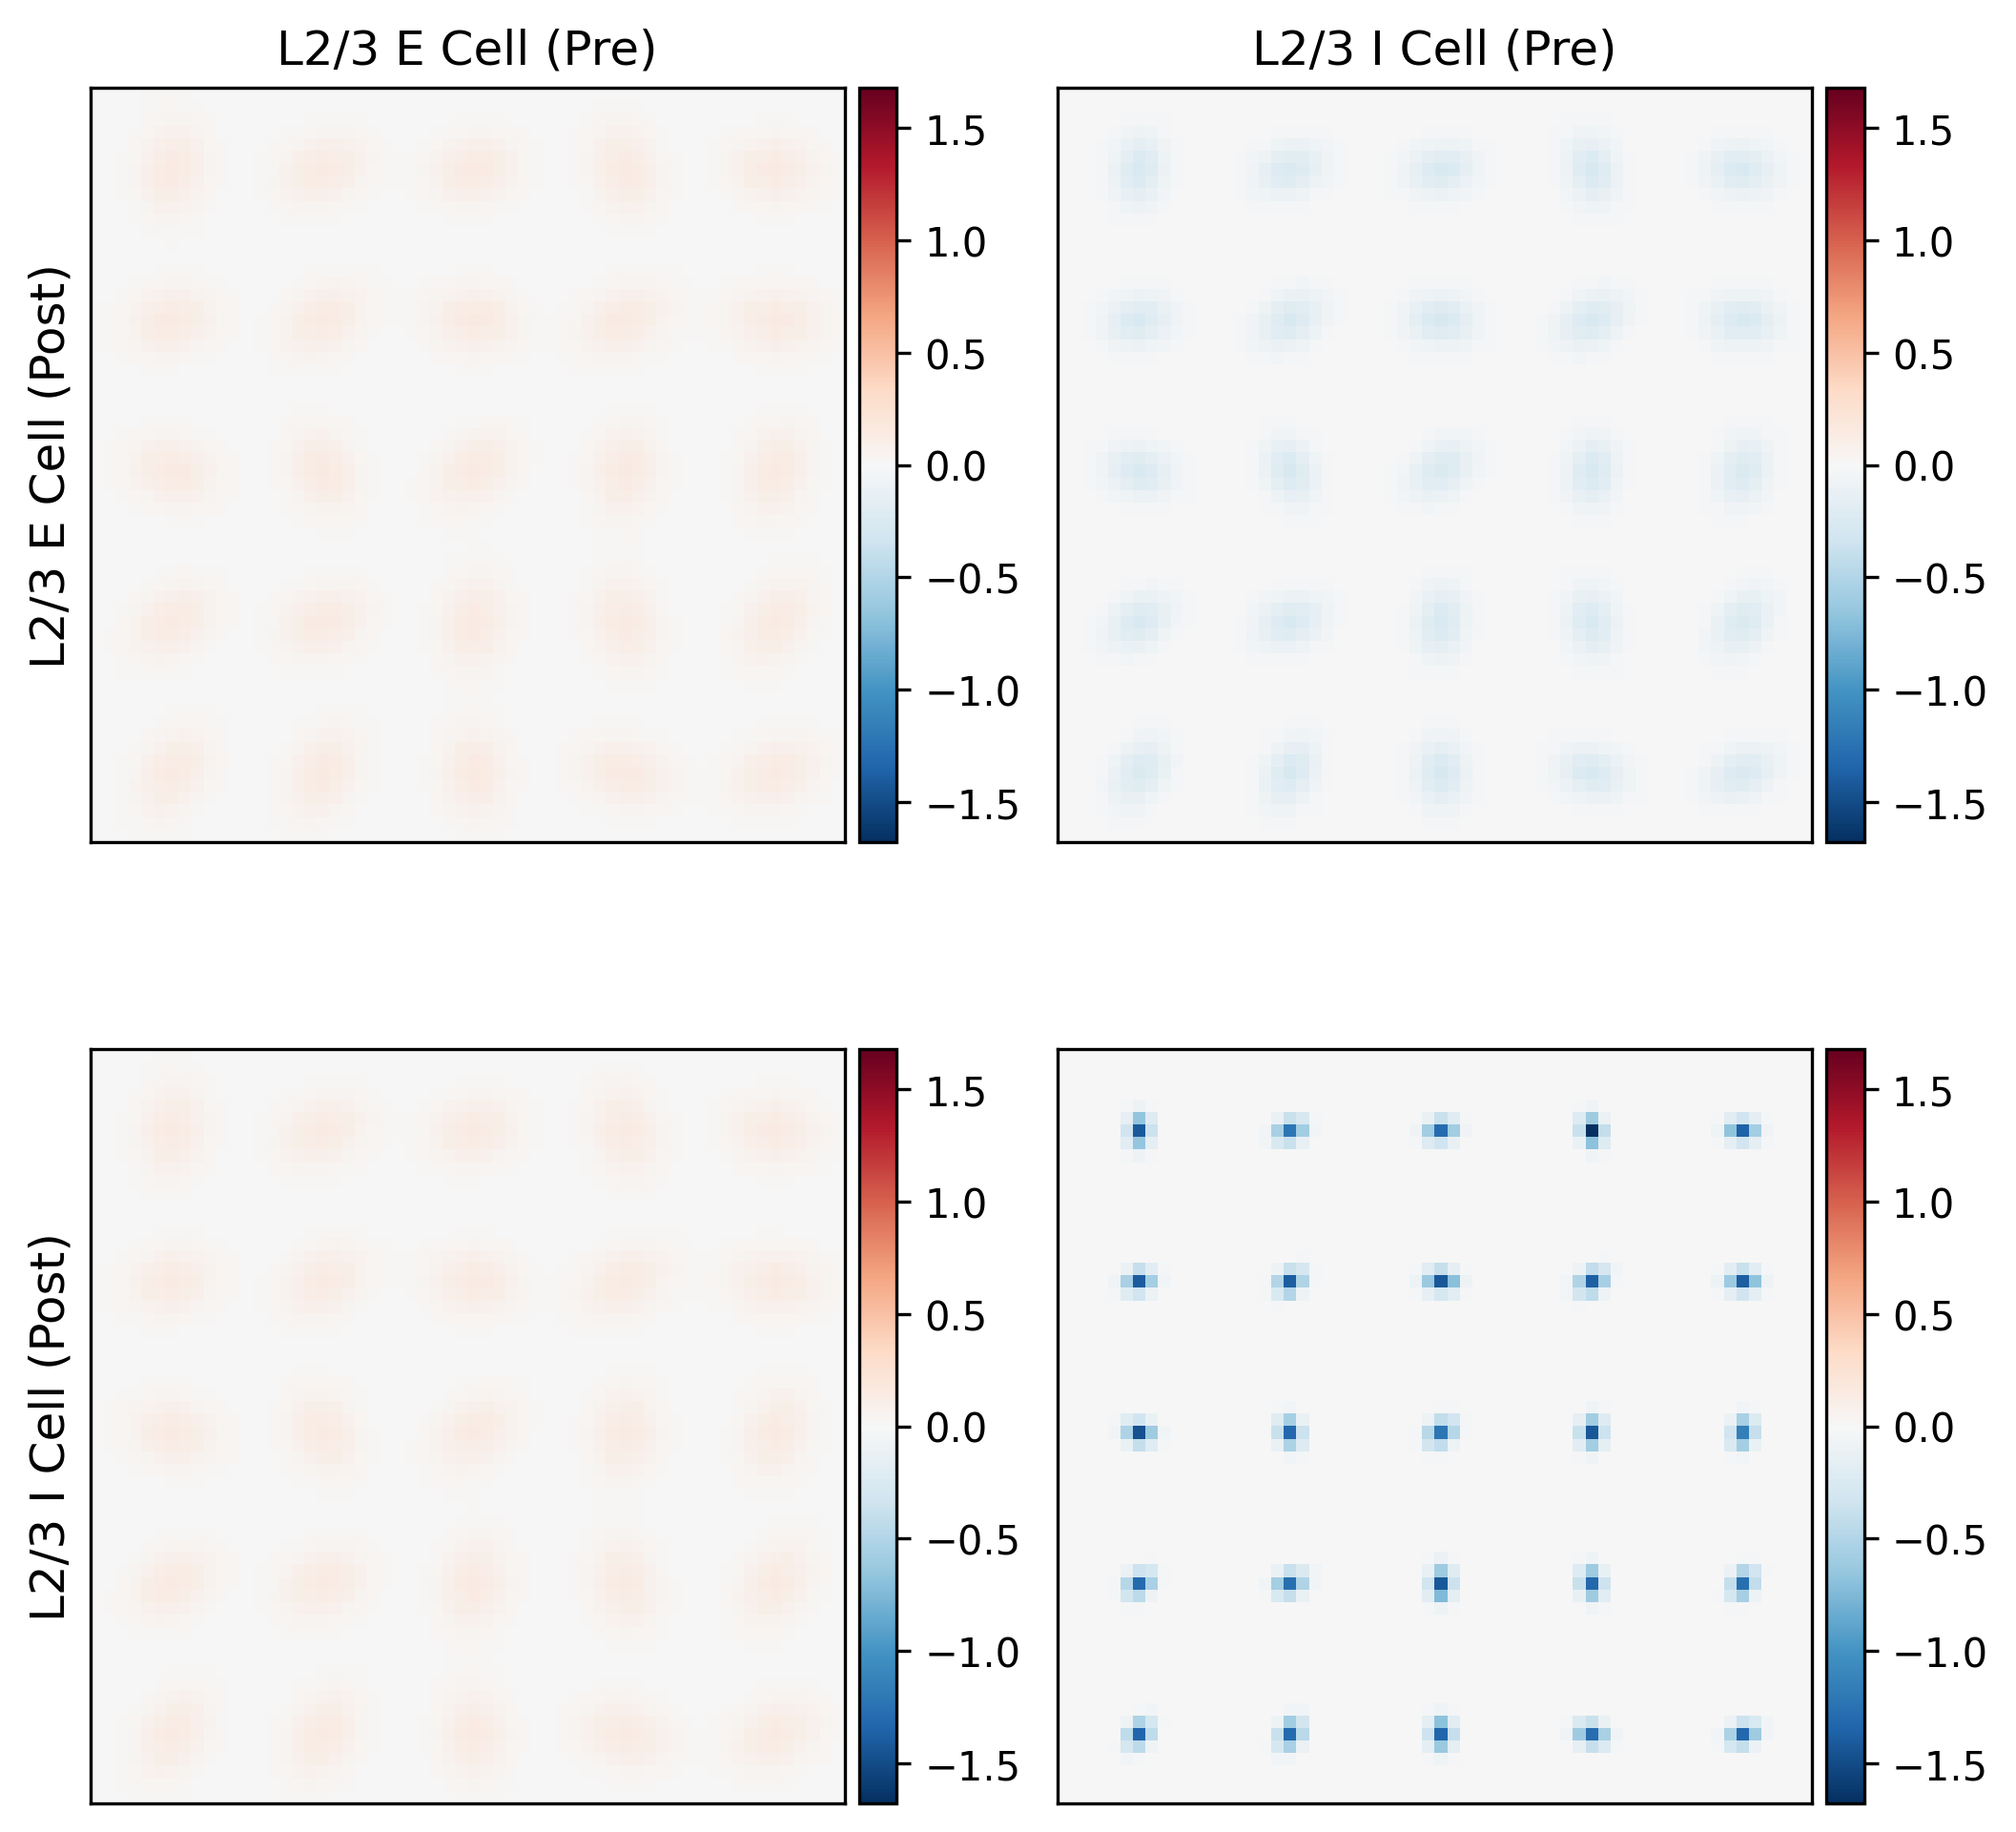

In [5]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

WEE = np.zeros((N4,N4))
WEI = np.zeros((N4,N4))
WIE = np.zeros((N4,N4))
WII = np.zeros((N4,N4))

idxs = np.arange(N4//10,N4,N4//5)
for i in range(len(idxs)):
    for j in range(len(idxs)):
        rav_idx = np.ravel_multi_index([[idxs[i]],[idxs[j]]],(N4,N4))
        WEE += W4to4[:N4**2,:N4**2][:,rav_idx].reshape(N4,N4)
        WEI += W4to4[:N4**2,N4**2:][:,rav_idx].reshape(N4,N4)
        WIE += W4to4[N4**2:,:N4**2][:,rav_idx].reshape(N4,N4)
        WII += W4to4[N4**2:,N4**2:][:,rav_idx].reshape(N4,N4)

pf.imshowbar(fig,axs[0,0],WEE,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[0,1],WEI,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,0],WIE,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,1],WII,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')

axs[0,0].set_ylabel('L2/3 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L2/3 I Cell (Post)',fontsize=12)
axs[0,0].set_title('L2/3 E Cell (Pre)',fontsize=12)
axs[0,1].set_title('L2/3 I Cell (Pre)',fontsize=12)

# eigval,eigvec = sparse.linalg.eigs(W4to4,1,which='LR')
# print(eigval)

# Construct Quasi-Periodic OPM for L4

In [6]:
def gen_qp_opm(sf,nk,seed=0):
    rng = np.random.default_rng(seed)
    
    x,y = np.meshgrid(np.arange(N4)/N4,np.arange(N4)/N4)

    z = np.zeros_like(x)
    
    for j in range(nk):
        fj = np.array([np.round(sf*np.cos(j*np.pi/nk)),
                       np.round(sf*np.sin(j*np.pi/nk))])
        sj = rng.choice([1,-1])
        phij = rng.random()*2*np.pi
        tmp = 2*np.pi*(x*fj[0]+y*fj[1])*sj + phij
        z = z + np.exp(1j * tmp)
        
    return z / nk

In [7]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def cross(A,B):
    return A[0]*B[1] - A[1]*B[0]

def intersectpt(A,B,C,D):
    qmp = [C[0]-A[0],C[1]-A[1]]
    r = [B[0]-A[0],B[1]-A[1]]
    s = [D[0]-C[0],D[1]-C[1]]
    rxs = cross(r,s)
    
    t = cross(qmp,s)/rxs
#     u = cross(qmp,r)/rxs
    
    return [A[0]+t*r[0],A[1]+t*r[1]]

In [8]:
z = gen_qp_opm(4,8)

Text(0.5, 1.0, 'Orientation Selectivity Map')

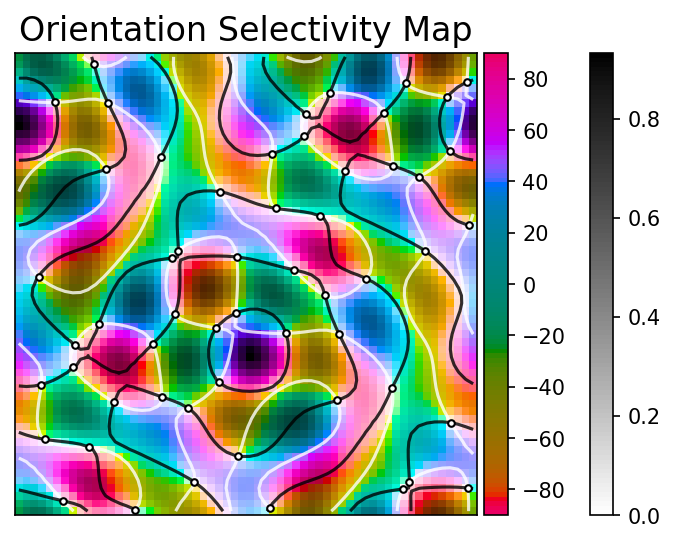

In [9]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=150)

pf.domcolbar(fig,axs,z,origin='lower',alim=[-90,90],rlim=[0,None],zorder=0)
rcont = axs.contour(np.real(z),levels=[0],colors="w",alpha=0.8,zorder=1)
icont = axs.contour(np.imag(z),levels=[0],colors="k",alpha=0.8,zorder=1)

rsegpts = []
for pts in rcont.allsegs[0]:
    for i in range(len(pts)-1):
        rsegpts.append([pts[i],pts[i+1]])
rsegpts = np.array(rsegpts)

isegpts = []
for pts in icont.allsegs[0]:
    for i in range(len(pts)-1):
        isegpts.append([pts[i],pts[i+1]])
isegpts = np.array(isegpts)

pwpts = []

for rsegpt in rsegpts:
    for isegpt in isegpts:
        if intersect(rsegpt[0],rsegpt[1],isegpt[0],isegpt[1]):
            pwpts.append(intersectpt(rsegpt[0],rsegpt[1],isegpt[0],isegpt[1]))
pwpts = np.array(pwpts)

axs.scatter(pwpts[:,0],pwpts[:,1],s=10,c='w',edgecolors='k',zorder=2)

axs.set_title('Orientation Selectivity Map',fontsize=16)

# Generate inputs

In [10]:
avg_OS = 0.15
avg_FF = 0.4

## Generate inputs with correct average OS

Text(0.5, 1.0, '$\\theta = 135^\\circ$')

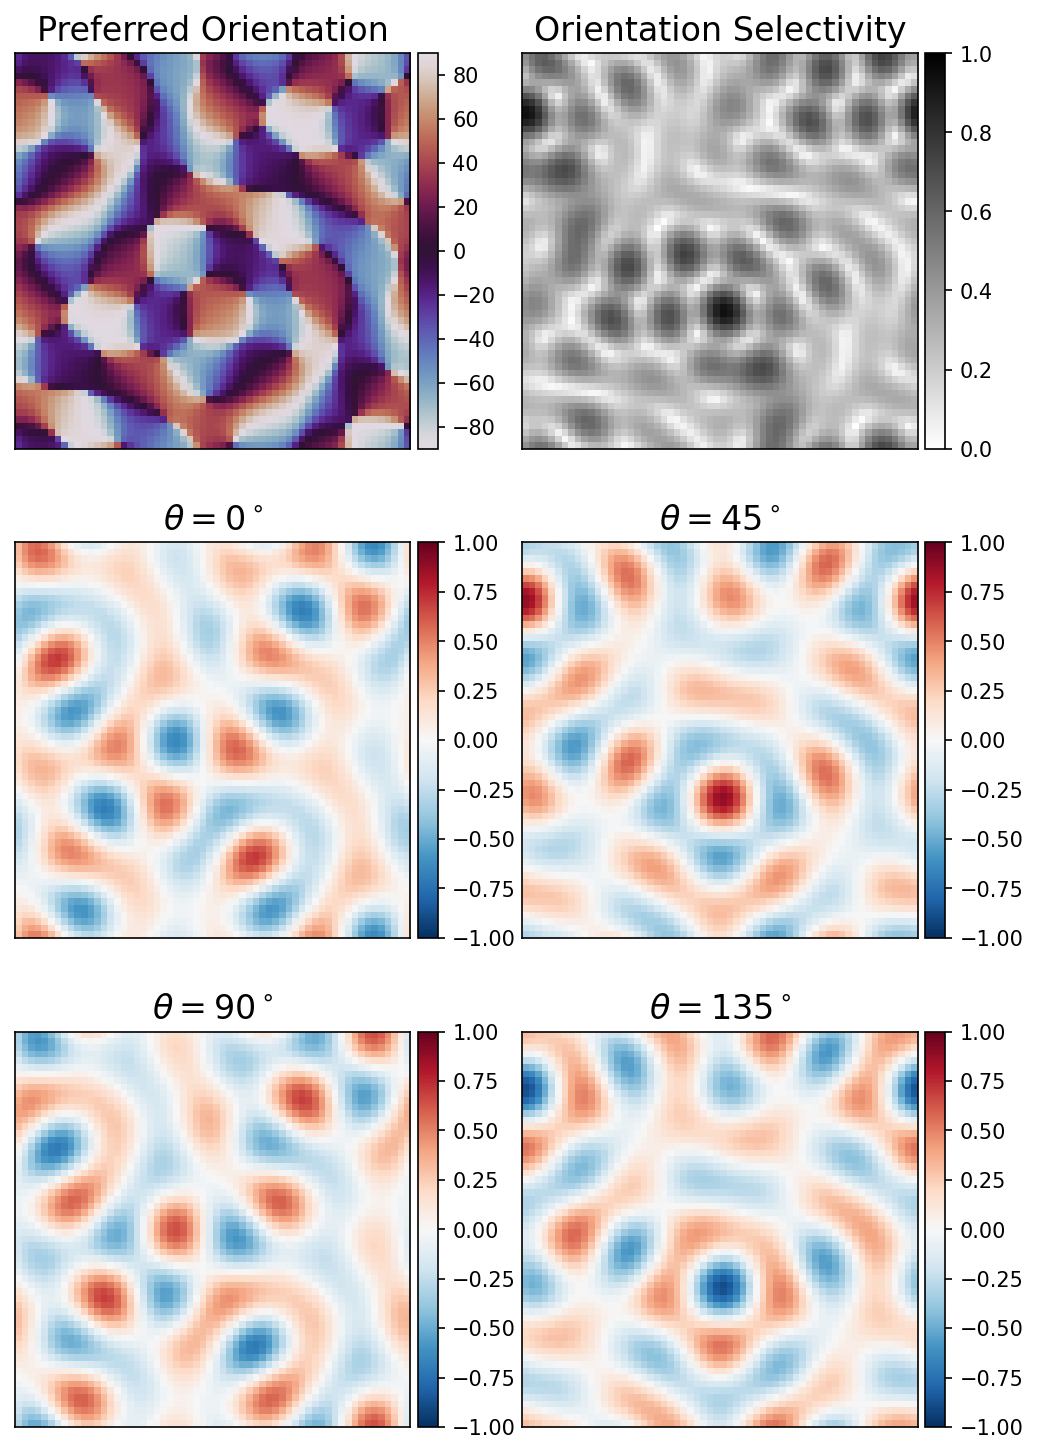

In [11]:
fig,axs = plt.subplots(3,2,figsize=(8,12),dpi=150)

pf.imshowbar(fig,axs[0,0],np.angle(z)*180/(2*np.pi),origin='lower',cmap='twilight',vmin=-90,vmax=90)

pf.imshowbar(fig,axs[0,1],np.abs(z),origin='lower',cmap='binary',vmin=0,vmax=1)

pf.imshowbar(fig,axs[1,0],np.real(np.exp(-1j*  0      ) * z),origin='lower',cmap='RdBu_r',
            vmin=-1,vmax=1)
pf.imshowbar(fig,axs[1,1],np.real(np.exp(-1j*  np.pi/2) * z),origin='lower',cmap='RdBu_r',
            vmin=-1,vmax=1)
pf.imshowbar(fig,axs[2,0],np.real(np.exp(-1j*  np.pi  ) * z),origin='lower',cmap='RdBu_r',
            vmin=-1,vmax=1)
pf.imshowbar(fig,axs[2,1],np.real(np.exp(-1j*3*np.pi/2) * z),origin='lower',cmap='RdBu_r',
            vmin=-1,vmax=1)

axs[0,0].set_title('Preferred Orientation',fontsize=16)
axs[0,1].set_title('Orientation Selectivity',fontsize=16)
axs[1,0].set_title(r'$\theta = 0^\circ$',fontsize=16)
axs[1,1].set_title(r'$\theta = 45^\circ$',fontsize=16)
axs[2,0].set_title(r'$\theta = 90^\circ$',fontsize=16)
axs[2,1].set_title(r'$\theta = 135^\circ$',fontsize=16)

In [12]:
n_inp = 25
oris = np.zeros(n_inp)
inps = np.zeros((n_inp,N4,N4))

# ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,0,N4/4))

rng = np.random.default_rng(0)
for inp_idx in range(n_inp):
    ori = inp_idx/n_inp*180
    oris[inp_idx] = ori
    mean_resp = 1 + 2*avg_OS * np.real(np.exp(1j*ori*2*np.pi/180) * z) / np.mean(np.abs(z))
    inps[inp_idx,:,:] = mean_resp

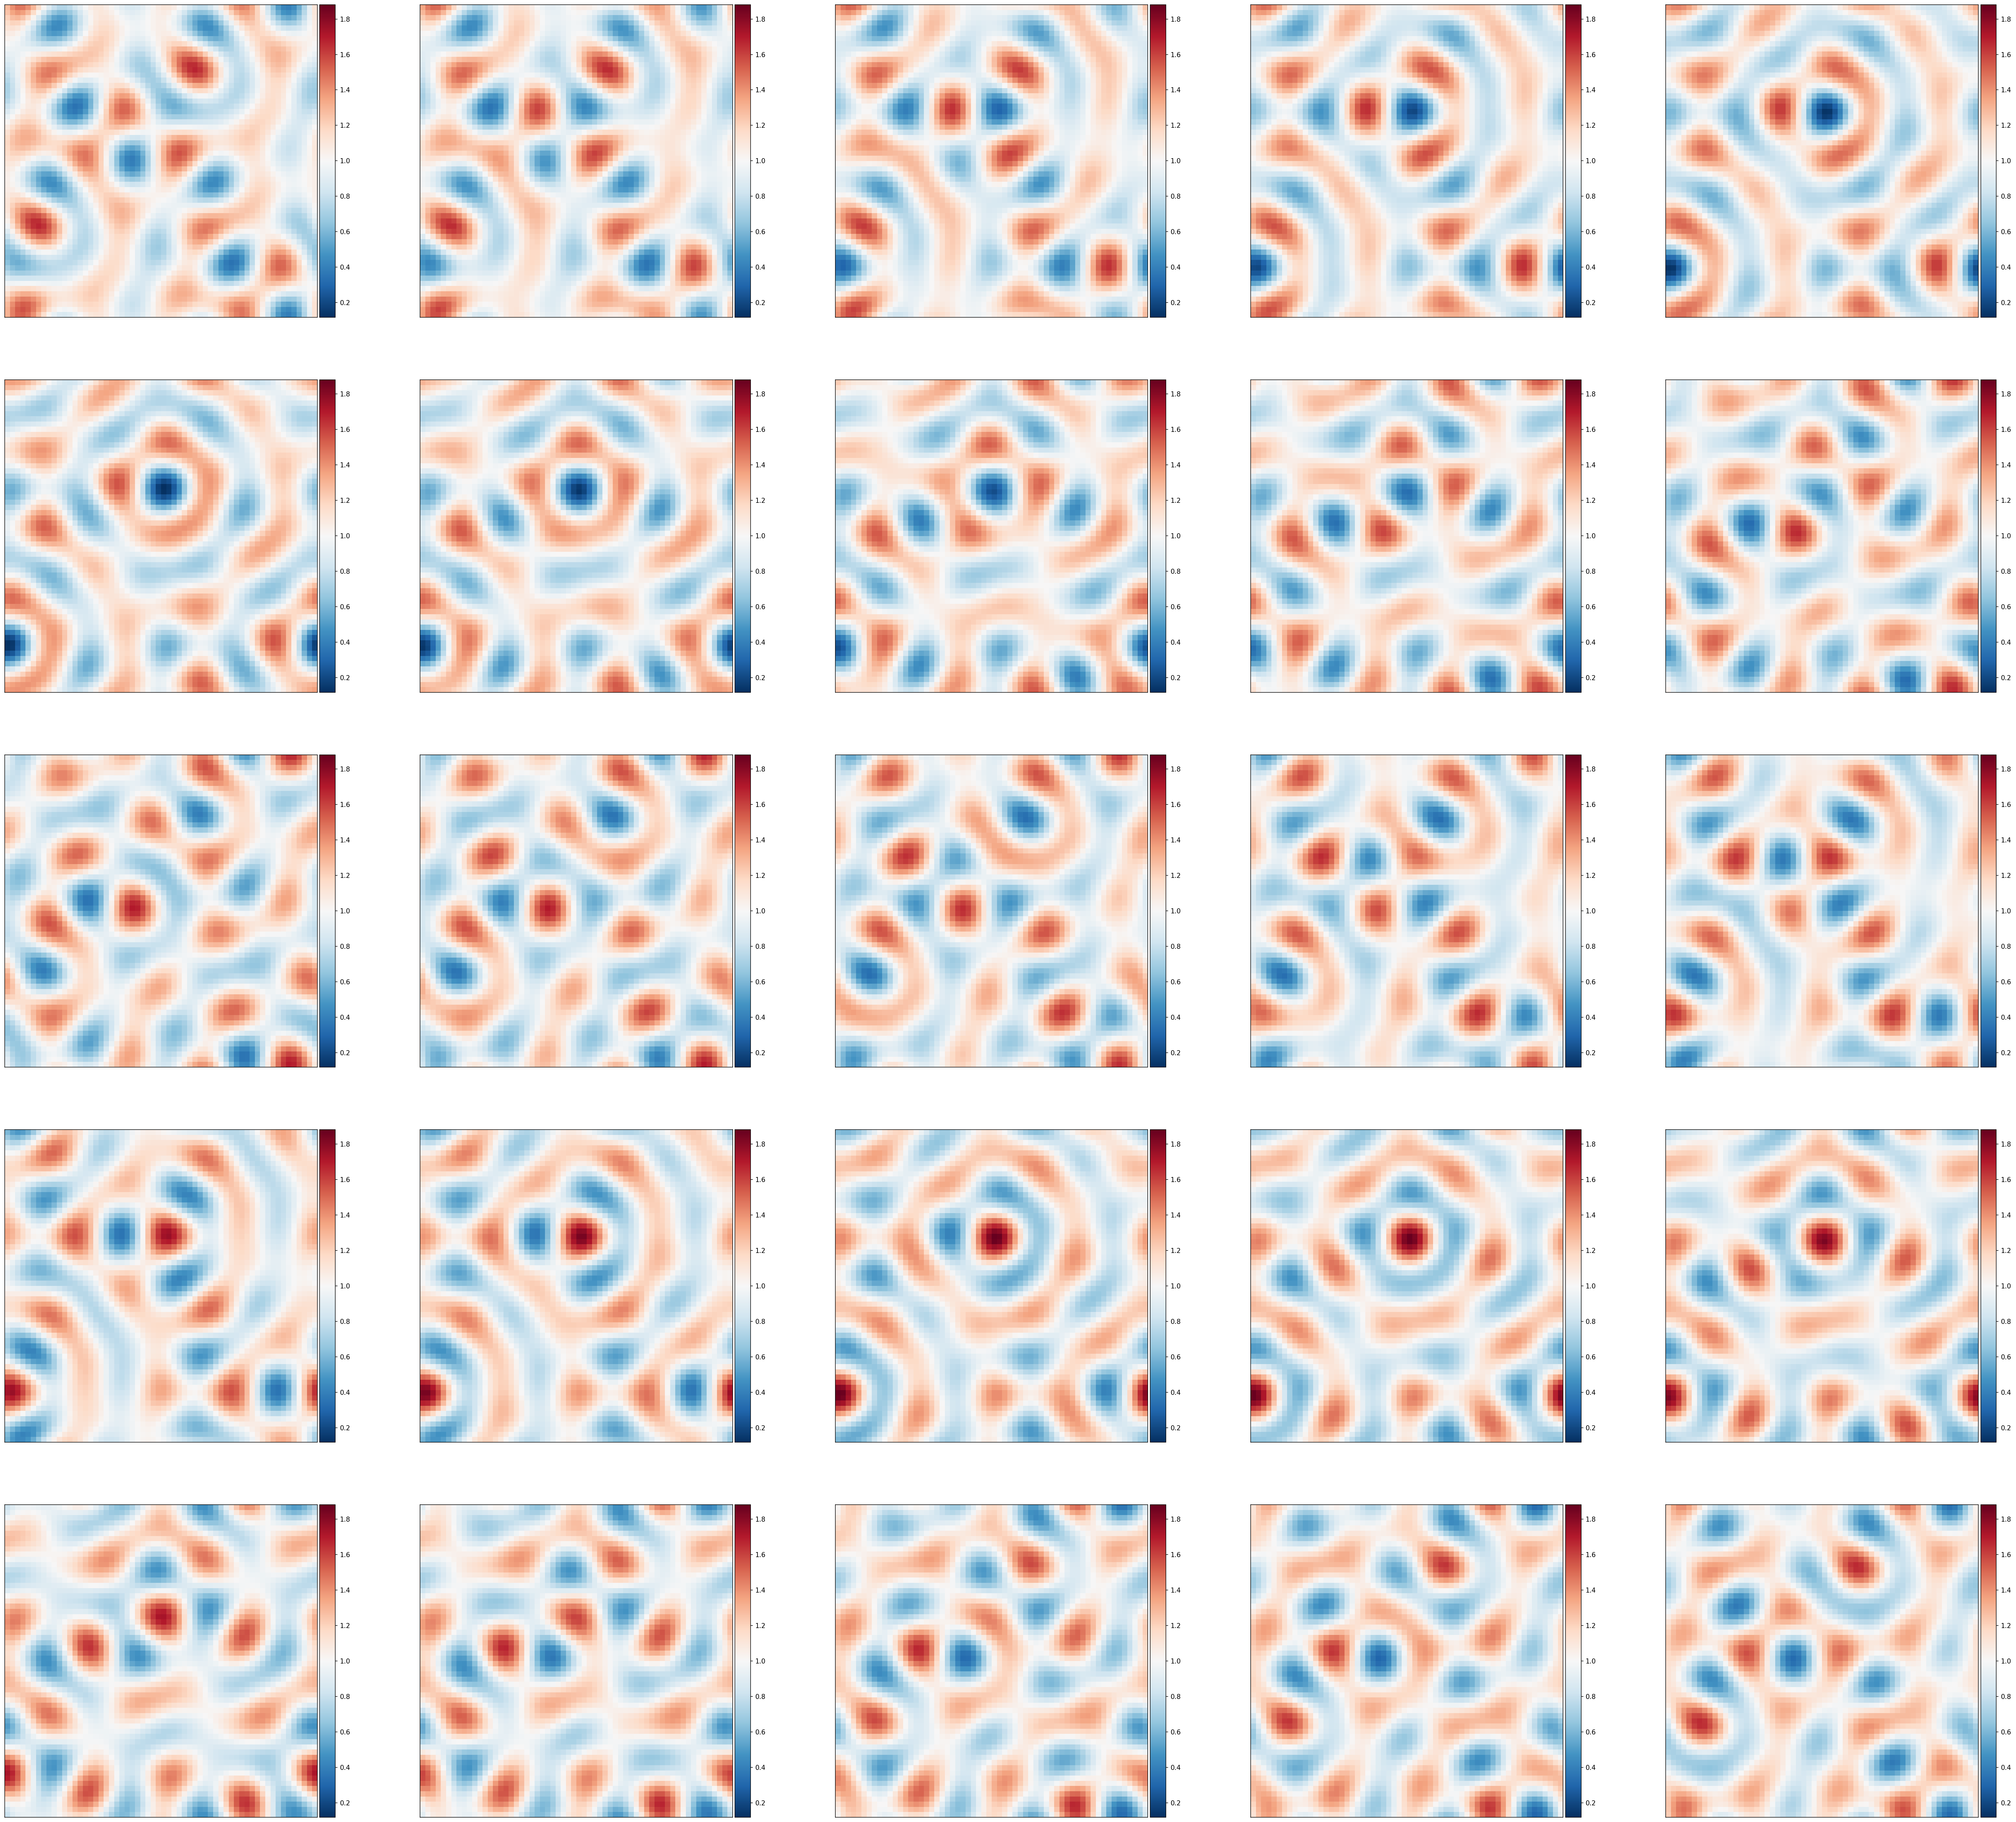

In [13]:
n_row = 5

fig,axs = plt.subplots(n_row,n_row,figsize=(55,50),dpi=150)

for i in range(n_row):
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     inps[idx],cmap='RdBu_r',
                     vmin=np.min(inps[:]),vmax=np.max(inps[:]))

Text(0.5, 1.0, 'Variance of Input')

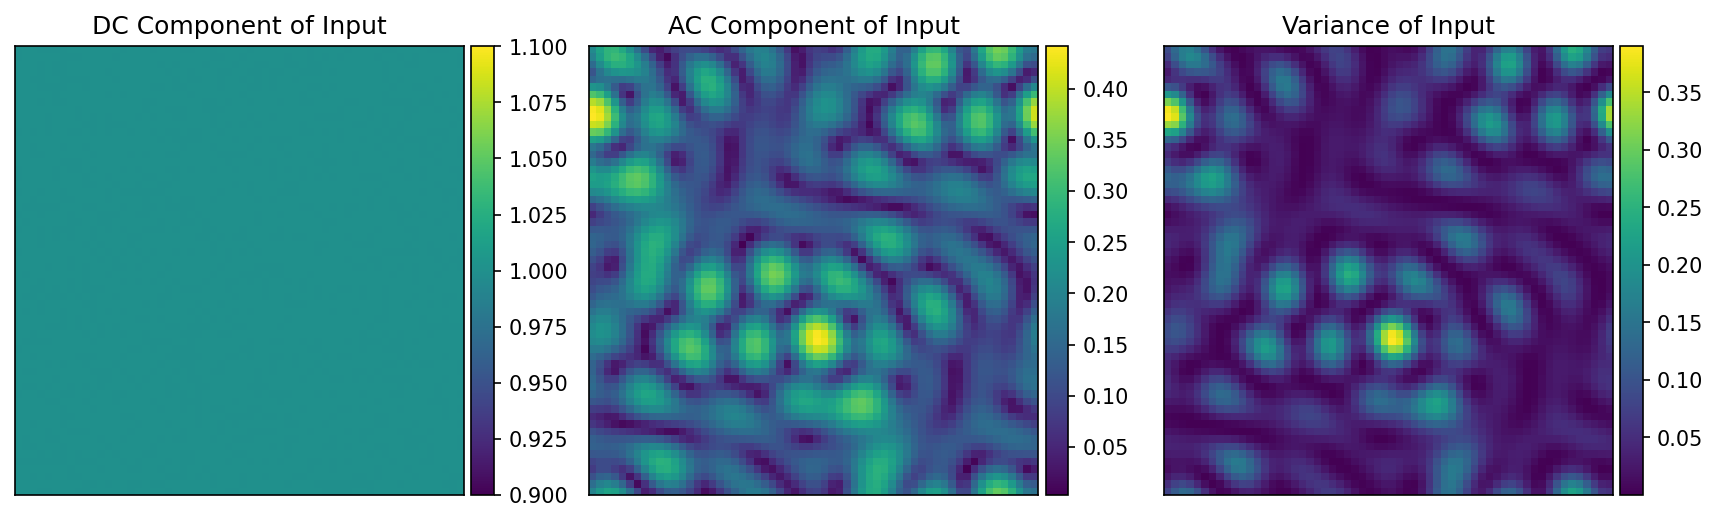

In [14]:
fig,axs = plt.subplots(1,3,figsize=(14,4),dpi=150)

r0 = np.mean(inps,0)
r1 = np.sqrt(np.mean(np.sin(oris*2*np.pi/180)[:,None,None]*inps,0)**2 +\
        np.mean(np.cos(oris*2*np.pi/180)[:,None,None]*inps,0)**2)
rV = np.var(inps,0)

pf.imshowbar(fig,axs[0],r0,origin='lower',cmap='viridis')
pf.imshowbar(fig,axs[1],r1,origin='lower',cmap='viridis')
pf.imshowbar(fig,axs[2],rV,origin='lower',cmap='viridis')

axs[0].set_title('DC Component of Input')
axs[1].set_title('AC Component of Input')
axs[2].set_title('Variance of Input')

In [15]:
print('Avg OS =',np.mean(r1/r0))
print('Variance from Orientation =',np.mean(rV))
ori_var = np.mean(rV)

Avg OS = 0.15
Variance from Orientation = 0.056041445528154855


## Generate inputs with correct FF

In [16]:
n_inp = 100
oris = np.zeros(n_inp)
inps = np.zeros((n_inp,N4,N4))

# ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,0,N4/4))

rng = np.random.default_rng(0)
for inp_idx in range(n_inp):
    ori = 0
    oris[inp_idx] = ori
    mean_resp = 1 + 2*avg_OS * np.real(np.exp(-1j*ori*2*np.pi/180) * z) / np.mean(np.abs(z))
    scale = avg_FF
    shape = mean_resp/avg_FF
#     random_matrix = rng.normal(size=(N4,N4))
#     inps[inp_idx,:,:] = mean_resp + random_matrix*np.sqrt(mean_resp*avg_FF)
    inps[inp_idx,:,:] = rng.gamma(shape=shape,scale=scale)

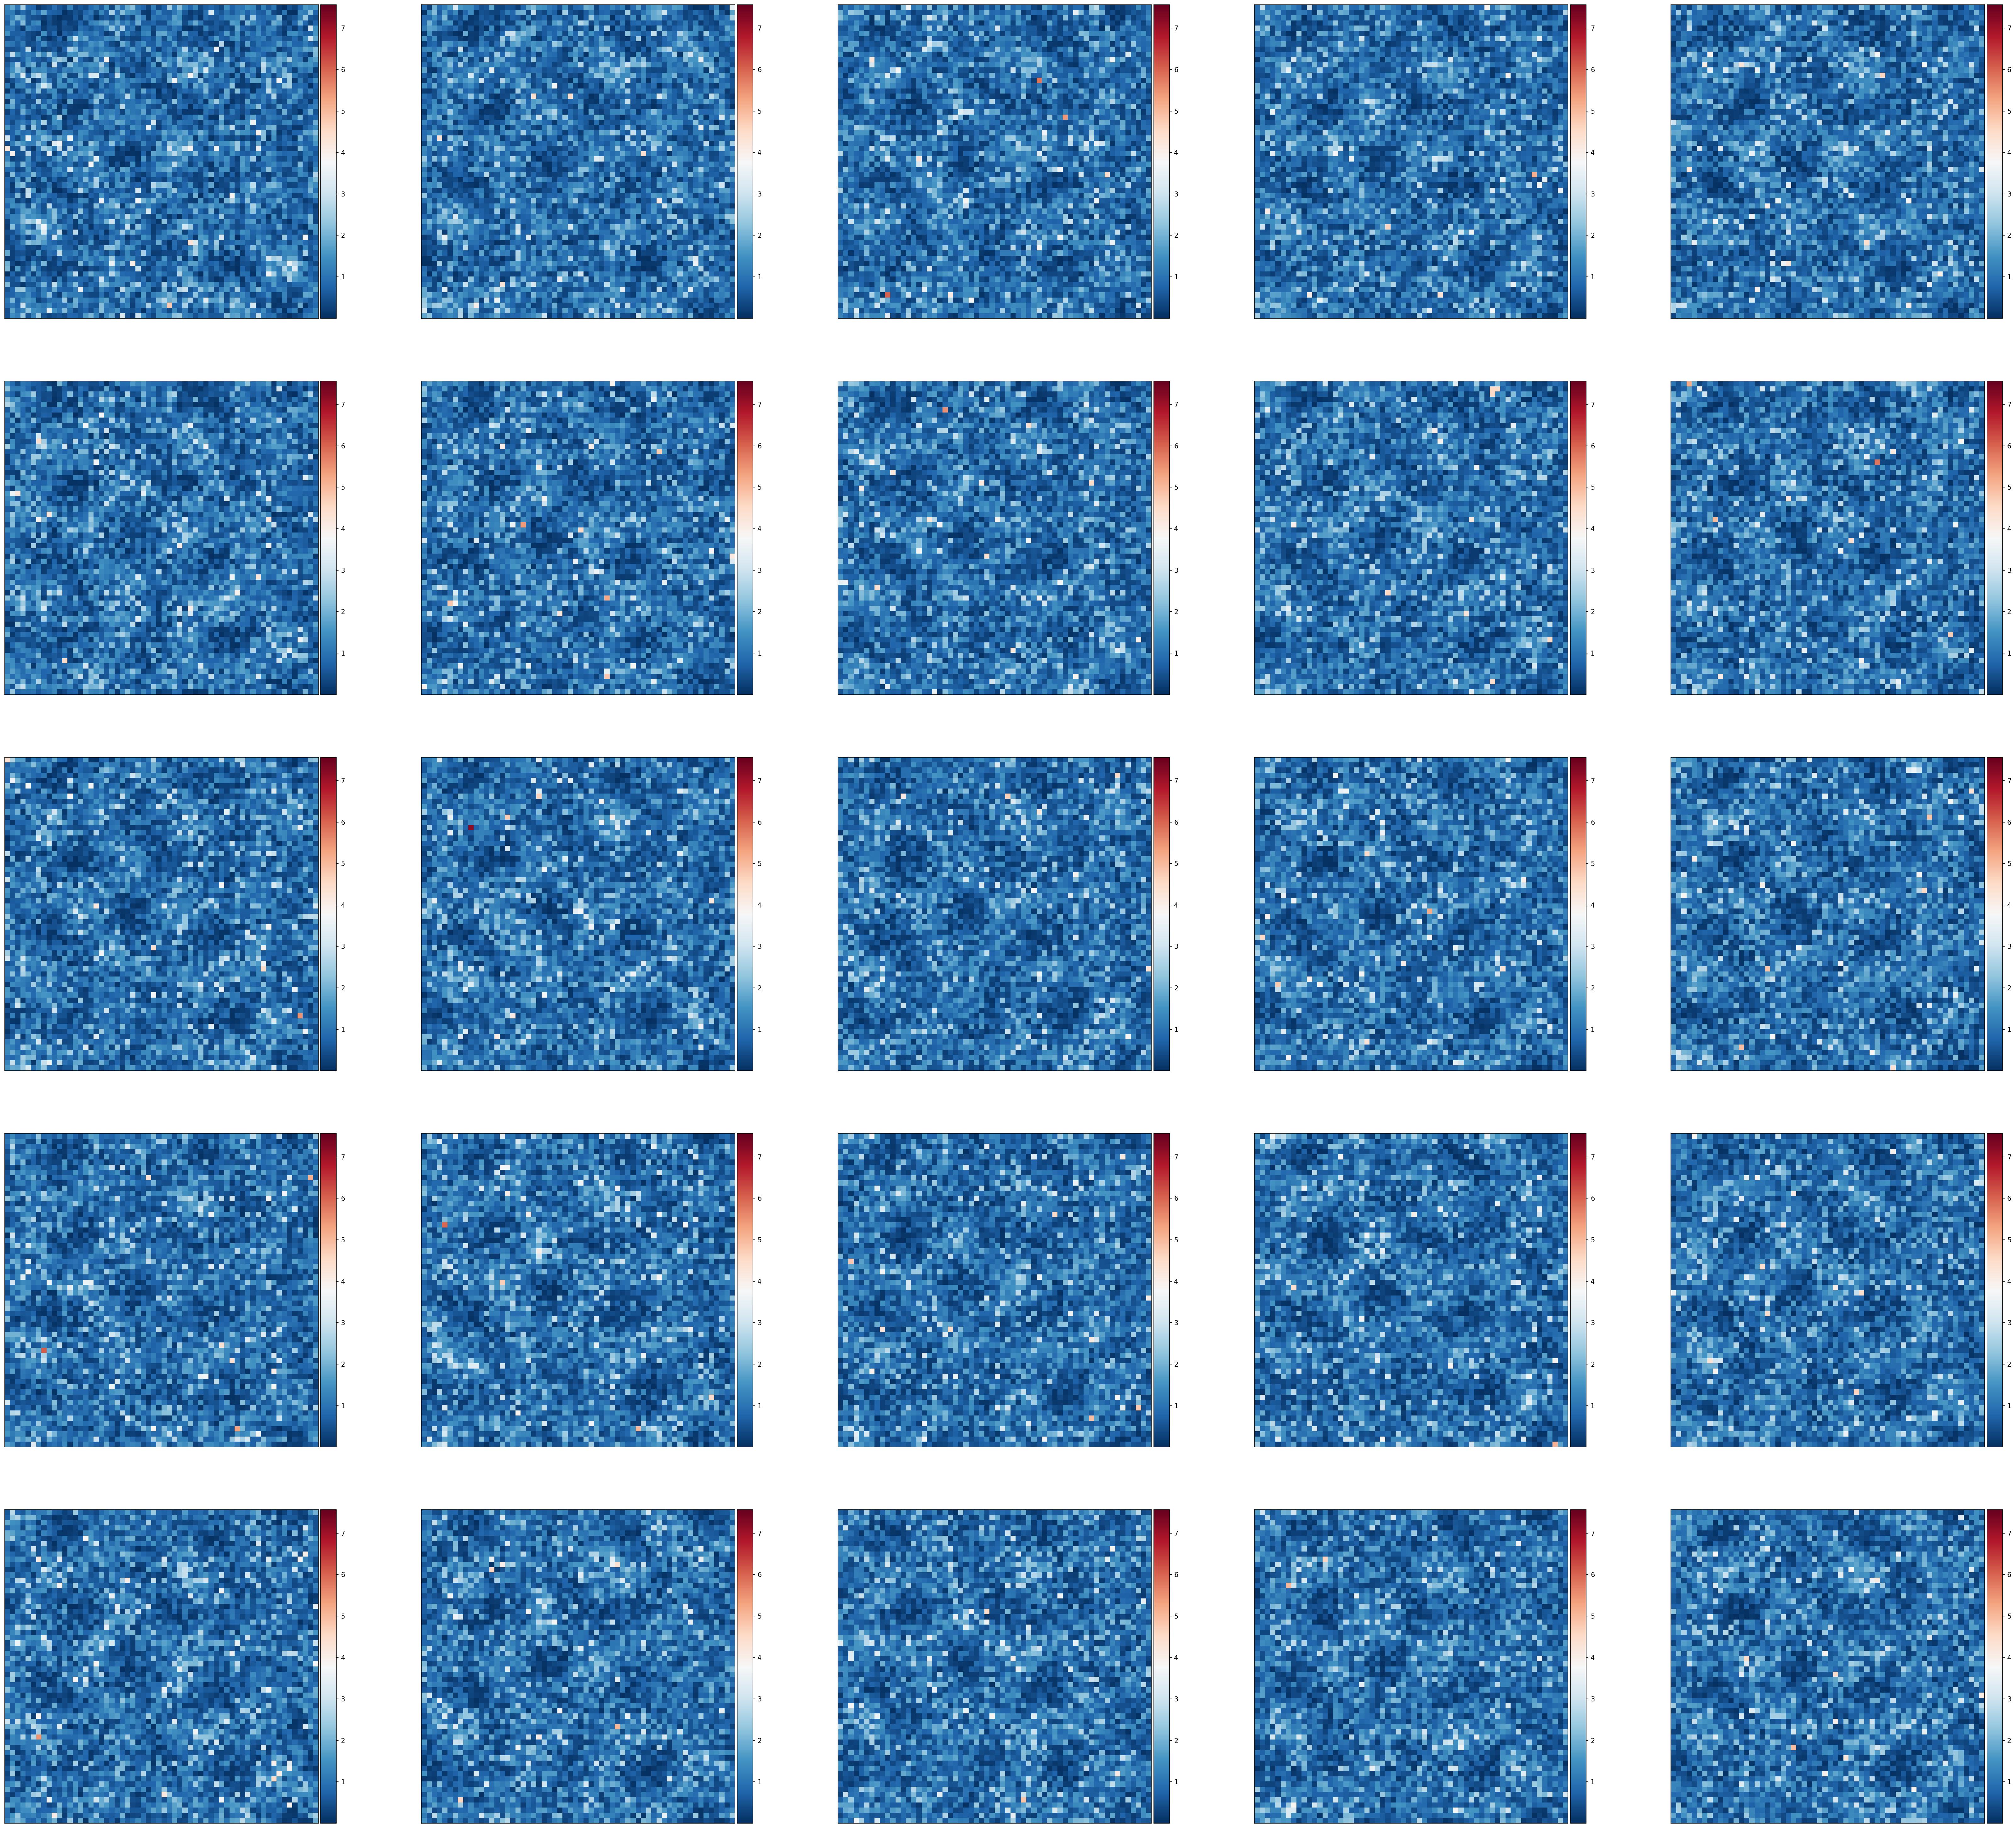

In [17]:
n_row = 5

fig,axs = plt.subplots(n_row,n_row,figsize=(55,50),dpi=150)

for i in range(n_row):
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     inps[idx],cmap='RdBu_r',
                     vmin=np.min(inps[:]),vmax=np.max(inps[:]))

Text(0.5, 1.0, 'Fano Factor of Input')

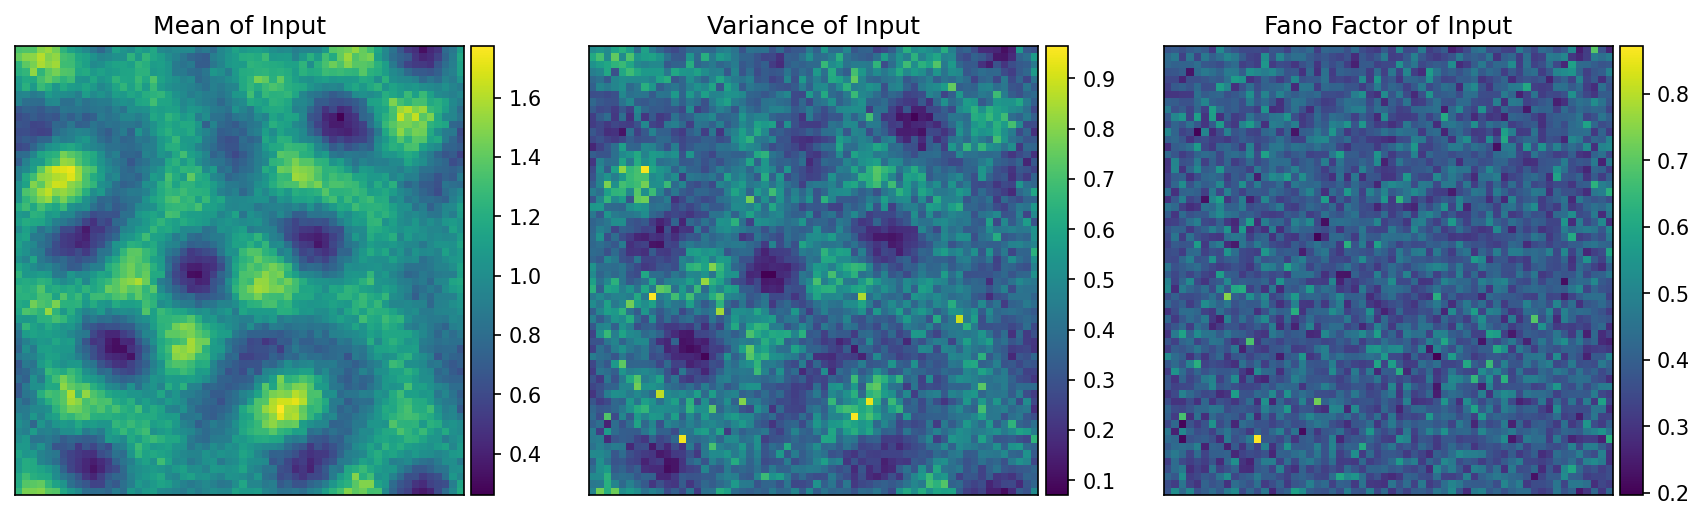

In [18]:
fig,axs = plt.subplots(1,3,figsize=(14,4),dpi=150)

rm = np.mean(inps,0)
rV = np.var(inps,0)

pf.imshowbar(fig,axs[0],rm,origin='lower',cmap='viridis')
pf.imshowbar(fig,axs[1],rV,origin='lower',cmap='viridis')
pf.imshowbar(fig,axs[2],rV/rm,origin='lower',cmap='viridis')

axs[0].set_title('Mean of Input')
axs[1].set_title('Variance of Input')
axs[2].set_title('Fano Factor of Input')

In [19]:
print('Avg FF =',np.mean(rV/rm))

Avg FF = 0.3941534849994139


## Generate full set of inputs

In [20]:
n_inp = 500
oris = np.arange(n_inp)/n_inp * 180
inps = np.zeros((n_inp,2,N4,N4))

# ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,0,N4/4))

rng = np.random.default_rng(0)
for inp_idx in range(n_inp):
    ori = oris[inp_idx]
    mean_resp = 1 + 2*avg_OS * np.real(np.exp(-1j*ori*2*np.pi/180) * z) / np.mean(np.abs(z))
    scale = avg_FF
    shape = mean_resp/avg_FF
    for pop_idx in range(2):
        inps[inp_idx,pop_idx,:,:] = rng.gamma(shape=shape,scale=scale)

In [21]:
r0 = np.mean(inps,0)
r1 = np.sqrt(np.mean(np.sin(oris*2*np.pi/180)[:,None,None,None]*inps,0)**2 +\
        np.mean(np.cos(oris*2*np.pi/180)[:,None,None,None]*inps,0)**2)
print('Avg OS =',np.mean(r1/r0))

rm = np.mean(inps,0)
rV = np.var(inps,0)
print('Avg FF =',np.mean(rV/rm) - ori_var)

Avg OS = 0.15219971397103393
Avg FF = 0.39921184762316886


In [22]:
# rates = np.zeros_like(inps)

# start = time.process_time()

# for inp_idx in range(n_inp):
#     rates[inp_idx] = integrate(np.ones(2*N4**2),inps[inp_idx].reshape((2,-1)),0.25,100)
    
# print('Simulating rate dynamics took',time.process_time() - start,'s')
# np.save('L23_rates_qp_map_N4={:d}'.format(N4),rates.flatten())

rates = np.load('L23_rates_qp_map_N4={:d}.npy'.format(N4)).reshape((n_inp,2,N4,N4))

In [23]:
n_row = 5

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=(110,50),dpi=150)

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     rates[idx,0],cmap='RdBu_r',
                     vmin=np.min(rates[:,0]),vmax=np.max(rates[:,0]))
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     rates[idx,1],cmap='RdBu_r',
                     vmin=np.min(rates[:,1]),vmax=np.max(rates[:,1]))

In [24]:
n_bins = 1
ori_binned = oris.reshape(-1,n_bins).mean(1)
inp_binned = inps.reshape(-1,n_bins,2,N4,N4).mean((1,2))
rate_binned = rates.reshape(-1,n_bins,2,N4,N4).mean((1,2))

In [26]:
r0 = np.mean(rate_binned,0)
rs = np.mean(np.sin(ori_binned*2*np.pi/180)[:,None,None]*rate_binned,0)
rc = np.mean(np.cos(ori_binned*2*np.pi/180)[:,None,None]*rate_binned,0)
r1 = np.sqrt(rs**2 + rc**2)

inp_r0 = np.mean(inp_binned,0)
inp_rs = np.mean(np.sin(ori_binned*2*np.pi/180)[:,None,None]*inp_binned,0)
inp_rc = np.mean(np.cos(ori_binned*2*np.pi/180)[:,None,None]*inp_binned,0)
inp_r1 = np.sqrt(inp_rs**2 + inp_rc**2)
 
pref_ori = np.arctan2(rs,rc)*180/(2*np.pi)
pref_ori[pref_ori > 90] -= 180
alt_pref_ori = ori_binned[rate_binned.argmax(0)]
alt_pref_ori[alt_pref_ori > 90] -= 180
ori_sel = r1/r0
 
inp_pref_ori = np.arctan2(inp_rs,inp_rc)*180/(2*np.pi)
inp_pref_ori[inp_pref_ori > 90] -= 180
inp_alt_pref_ori = ori_binned[inp_binned.argmax(0)]
inp_alt_pref_ori[inp_alt_pref_ori > 90] -= 180
inp_ori_sel = inp_r1/inp_r0

z_field = ori_sel * np.exp(1j*pref_ori*2*np.pi/180)
inp_z_field = inp_ori_sel * np.exp(1j*inp_pref_ori*2*np.pi/180)

Text(0.5, 1.0, 'Orientation Map')

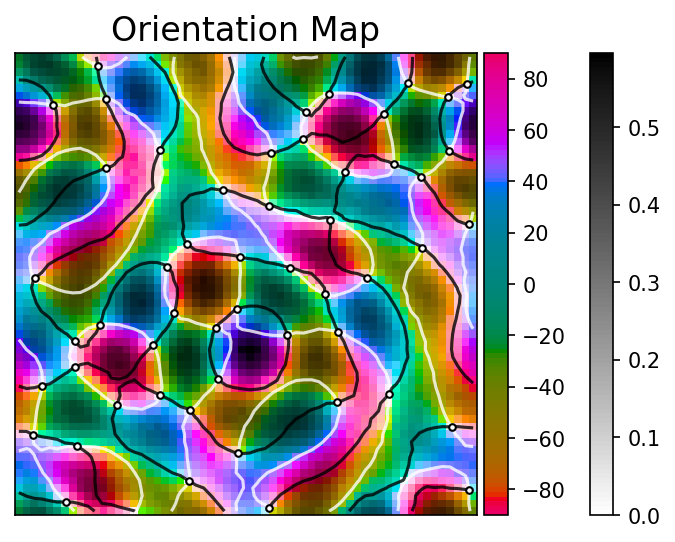

In [31]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=150)

pf.domcolbar(fig,axs,z_field,origin='lower',alim=[-90,90],rlim=[0,None],zorder=0)
rcont = axs.contour(np.real(z_field),levels=[0],colors="w",alpha=0.8,zorder=1)
icont = axs.contour(np.imag(z_field),levels=[0],colors="k",alpha=0.8,zorder=1)

rsegpts = []
for pts in rcont.allsegs[0]:
    for i in range(len(pts)-1):
        rsegpts.append([pts[i],pts[i+1]])
rsegpts = np.array(rsegpts)

isegpts = []
for pts in icont.allsegs[0]:
    for i in range(len(pts)-1):
        isegpts.append([pts[i],pts[i+1]])
isegpts = np.array(isegpts)

pwpts = []

for rsegpt in rsegpts:
    for isegpt in isegpts:
        if intersect(rsegpt[0],rsegpt[1],isegpt[0],isegpt[1]):
            pwpts.append(intersectpt(rsegpt[0],rsegpt[1],isegpt[0],isegpt[1]))
pwpts = np.array(pwpts)

axs.scatter(pwpts[:,0],pwpts[:,1],s=10,c='w',edgecolors='k',zorder=2)

axs.set_title('Orientation Map',fontsize=16)

# Compare L4 vs L2/3 OPM

## Compare maps

Text(0.5, 1.0, 'L2/3 Activity Orientation Selectivity')

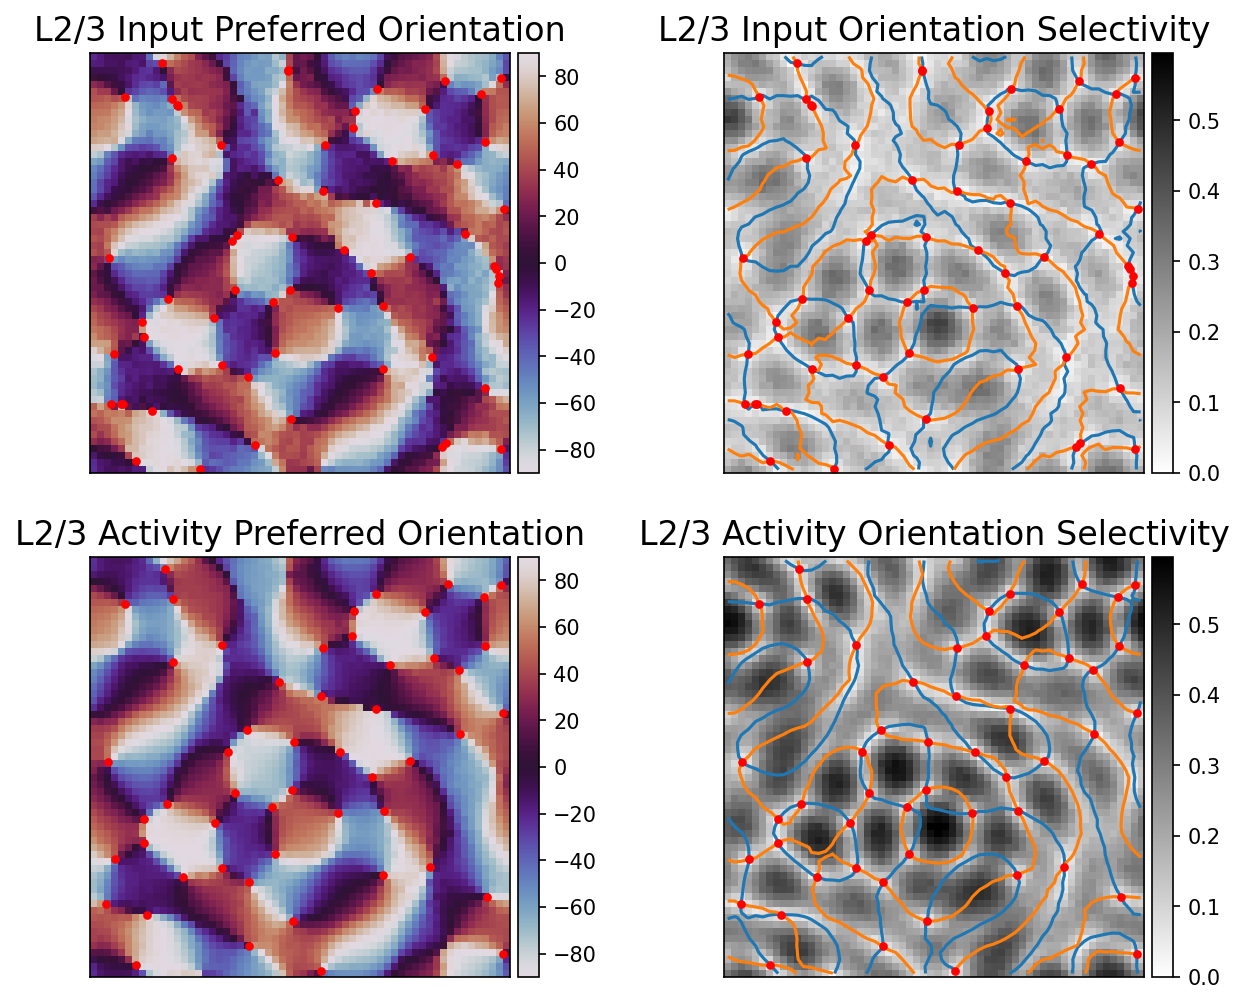

In [37]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=150)

pf.imshowbar(fig,axs[0,0],inp_pref_ori,origin='lower',cmap='twilight',vmin=-90,vmax=90,zorder=0)

pf.imshowbar(fig,axs[0,1],inp_ori_sel,origin='lower',cmap='binary',
             vmin=0,vmax=max(np.max(inp_ori_sel),np.max(ori_sel)),zorder=0)
rcont = axs[0,1].contour(np.real(inp_z_field),levels=[0],colors="C0",zorder=1)
icont = axs[0,1].contour(np.imag(inp_z_field),levels=[0],colors="C1",zorder=1)

rsegpts = []
for pts in rcont.allsegs[0]:
    for i in range(len(pts)-1):
        rsegpts.append([pts[i],pts[i+1]])
rsegpts = np.array(rsegpts)

isegpts = []
for pts in icont.allsegs[0]:
    for i in range(len(pts)-1):
        isegpts.append([pts[i],pts[i+1]])
isegpts = np.array(isegpts)

pwpts = []

for rsegpt in rsegpts:
    for isegpt in isegpts:
        if intersect(rsegpt[0],rsegpt[1],isegpt[0],isegpt[1]):
            pwpts.append(intersectpt(rsegpt[0],rsegpt[1],isegpt[0],isegpt[1]))
pwpts = np.array(pwpts)

axs[0,0].scatter(pwpts[:,0],pwpts[:,1],s=10,c='r',zorder=2)
axs[0,1].scatter(pwpts[:,0],pwpts[:,1],s=10,c='r',zorder=2)

pf.imshowbar(fig,axs[1,0],pref_ori,origin='lower',cmap='twilight',vmin=-90,vmax=90,zorder=0)

pf.imshowbar(fig,axs[1,1],ori_sel,origin='lower',cmap='binary',
             vmin=0,vmax=max(np.max(inp_ori_sel),np.max(ori_sel)),zorder=0)
rcont = axs[1,1].contour(np.real(z_field),levels=[0],colors="C0",zorder=1)
icont = axs[1,1].contour(np.imag(z_field),levels=[0],colors="C1",zorder=1)

rsegpts = []
for pts in rcont.allsegs[0]:
    for i in range(len(pts)-1):
        rsegpts.append([pts[i],pts[i+1]])
rsegpts = np.array(rsegpts)

isegpts = []
for pts in icont.allsegs[0]:
    for i in range(len(pts)-1):
        isegpts.append([pts[i],pts[i+1]])
isegpts = np.array(isegpts)

pwpts = []

for rsegpt in rsegpts:
    for isegpt in isegpts:
        if intersect(rsegpt[0],rsegpt[1],isegpt[0],isegpt[1]):
            pwpts.append(intersectpt(rsegpt[0],rsegpt[1],isegpt[0],isegpt[1]))
pwpts = np.array(pwpts)

axs[1,0].scatter(pwpts[:,0],pwpts[:,1],s=10,c='r',zorder=2)
axs[1,1].scatter(pwpts[:,0],pwpts[:,1],s=10,c='r',zorder=2)

axs[0,0].set_title('L2/3 Input Preferred Orientation',fontsize=16)
axs[0,1].set_title('L2/3 Input Orientation Selectivity',fontsize=16)
axs[1,0].set_title('L2/3 Activity Preferred Orientation',fontsize=16)
axs[1,1].set_title('L2/3 Activity Orientation Selectivity',fontsize=16)

In [29]:
print('L4 Avg OS =',np.mean(inp_ori_sel))
print('L2/3 Avg OS =',np.mean(ori_sel))

L4 Avg OS = 0.15122887454948333
L2/3 Avg OS = 0.260927585378534


## Look at orientation preference mismatch

In [33]:
opm_mismatch = np.abs(inp_pref_ori - pref_ori)
opm_mismatch[opm_mismatch > 90] = 180 - opm_mismatch[opm_mismatch > 90]

Text(0, 0.5, 'Count')

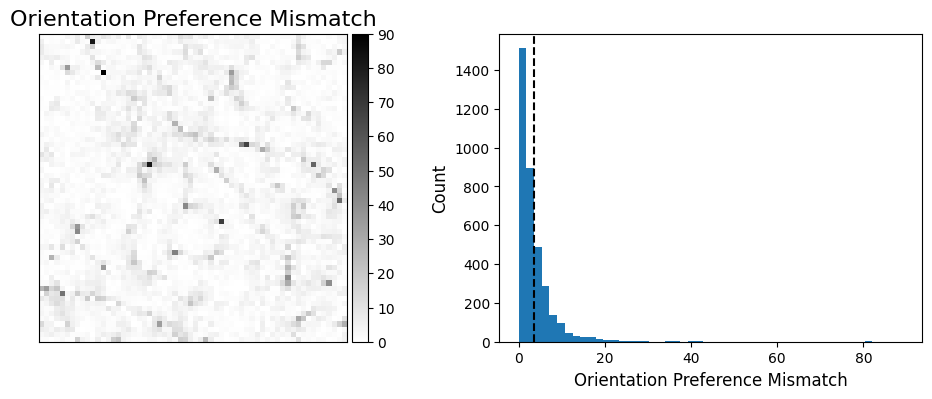

In [34]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

pf.imshowbar(fig,axs[0],opm_mismatch,
             origin='lower',cmap='binary',vmin=0,vmax=90)
axs[1].hist(opm_mismatch.flatten(),50)
axs[1].axvline(np.mean(opm_mismatch),c='k',ls='--')

axs[0].set_title('Orientation Preference Mismatch',fontsize=16)
axs[1].set_xlabel('Orientation Preference Mismatch',fontsize=12)
axs[1].set_ylabel('Count',fontsize=12)

In [35]:
np.mean(opm_mismatch)

3.647995250839346

# Try again but with smoothed S&P map

In [38]:
def gen_sp_opm(shape,seed=0):
    rng = np.random.default_rng(seed)
    
    z = np.exp(1j*2*np.pi*rng.random(size=(N4,N4)))
    z *= rng.gamma(shape=shape,scale=1/shape,size=(N4,N4))
    
    return z

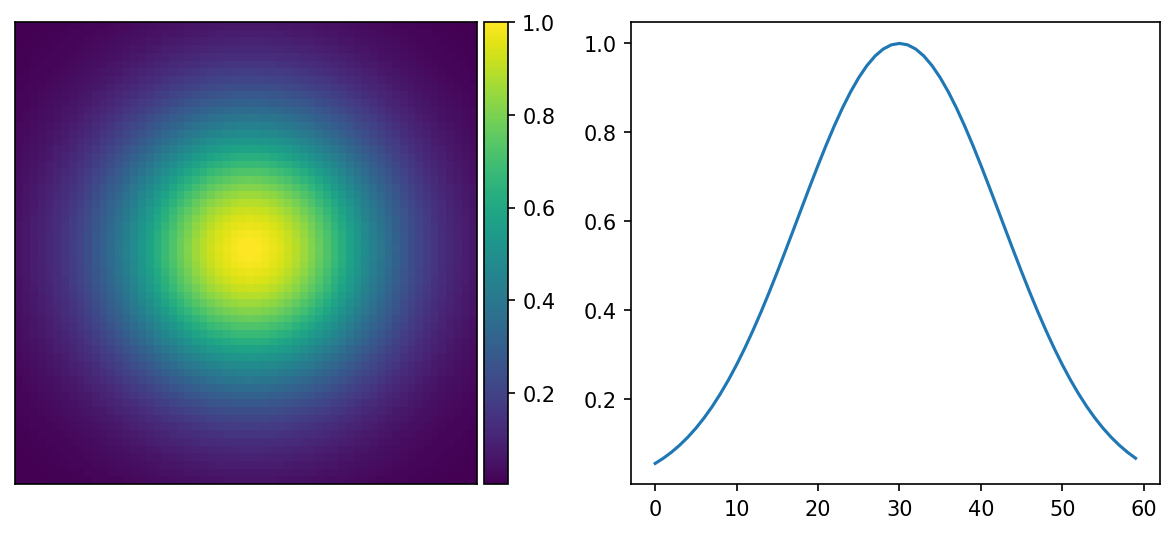

In [83]:
k = 0.01

orig_z = gen_sp_opm(k)

lker = 0.08
ltyp = 0.0
# lker = 0.1
# ltyp = 0.25

if lker != 0.0:
    if ltyp != 0.0:
        gauss = gen_gaussian_random_field.generate_ring(N4,N4,1/ltyp,1/lker)
    else:
        gauss = gen_gaussian_random_field.generate_ring(N4,N4,0,1/lker)
        
    fft_gauss = np.fft.fftshift(gauss) * np.sqrt(2*np.pi) * lker
        
    fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)
    pf.imshowbar(fig,axs[0],gauss,origin='lower',cmap='viridis')
    axs[1].plot(gauss[N4//2,:])
    
    z = np.fft.ifft2(np.fft.fft2(orig_z)*fft_gauss)

Text(0.5, 1.0, 'L2/3 Input Orientation Map')

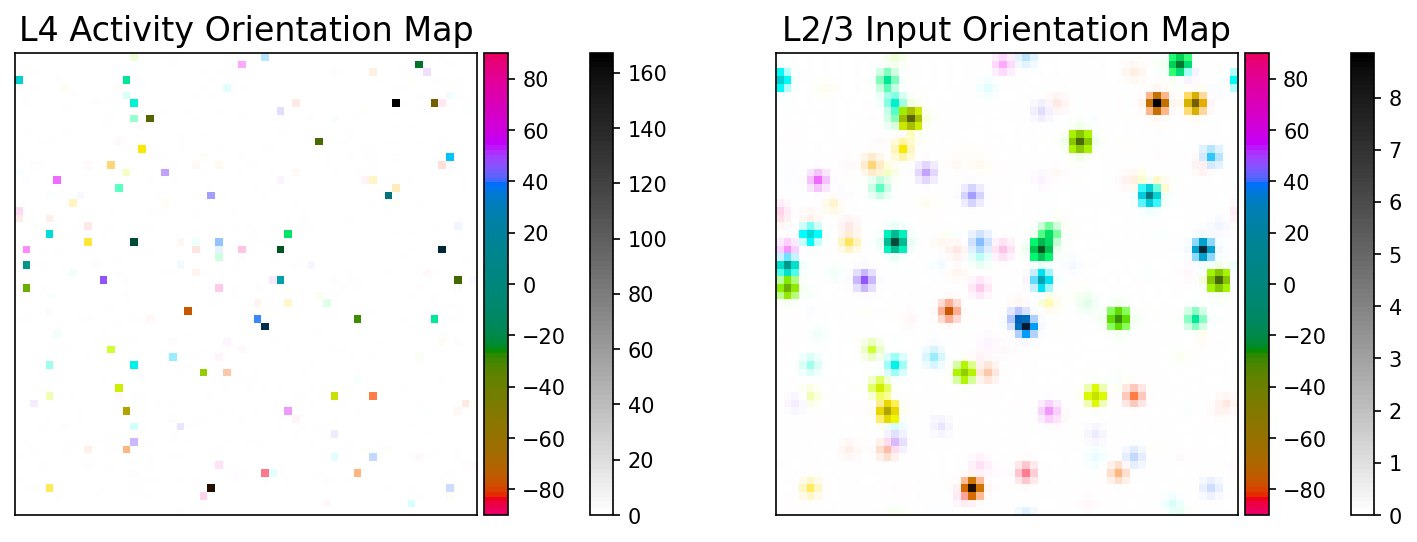

In [85]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=150)

pf.domcolbar(fig,axs[0],orig_z,origin='lower',alim=[-90,90],rlim=[0,None])
pf.domcolbar(fig,axs[1],z,origin='lower',alim=[-90,90],rlim=[0,None])

axs[0].set_title('L4 Activity Orientation Map',fontsize=16)
axs[1].set_title('L2/3 Input Orientation Map',fontsize=16)

In [64]:
ori = np.angle(z)*180/(2*np.pi)
sel = np.abs(z)
z_unit = z / sel
ori_fft = np.abs(np.fft.fftshift(np.fft.fft2(ori - np.nanmean(ori))))**2
z_unit_fft = np.abs(np.fft.fftshift(np.fft.fft2(z_unit - np.nanmean(z_unit))))**2
# ori_fps = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# z_unit_fps = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
ori_fps = np.zeros(N4//2)
z_unit_fps = np.zeros(N4//2)

grid = np.arange(-N4//2,N4//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(N4//2*np.sqrt(2)))+0.5)
for idx in range(N4//2):
    ori_fps[idx] = np.mean(ori_fft[bin_idxs == idx])
    z_unit_fps[idx] = np.mean(z_unit_fft[bin_idxs == idx])

Text(0.5, 1.0, '2D FPS of Normalized Z Field')

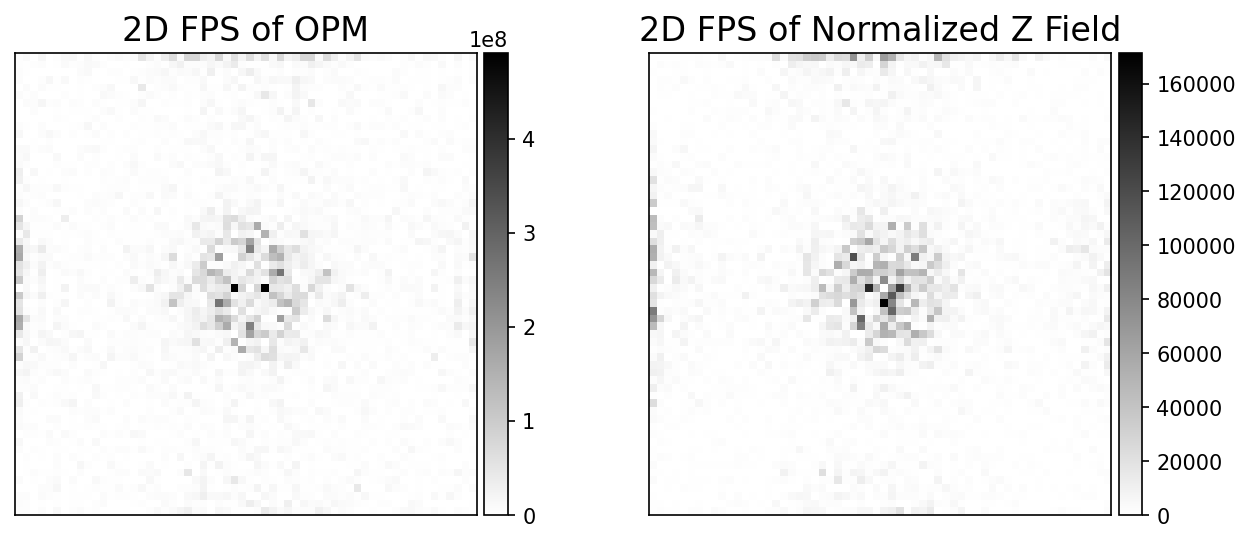

In [65]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)

pf.imshowbar(fig,axs[0],ori_fft,cmap='binary')
pf.imshowbar(fig,axs[1],z_unit_fft,cmap='binary')

axs[0].set_title('2D FPS of OPM',fontsize=16)
axs[1].set_title('2D FPS of Normalized Z Field',fontsize=16)

# Generate inputs

In [66]:
avg_OS = 0.15
avg_FF = 0.4

In [67]:
n_inp = 500
gam_rec = 1.02
oris = np.arange(n_inp)/n_inp * 180
inps = np.zeros((n_inp,2,N4,N4))

# ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,0,N4/4))

rng = np.random.default_rng(0)
for inp_idx in range(n_inp):
    ori = oris[inp_idx]
    mean_resp = np.fmax(0,1 + 2*avg_OS * np.real(np.exp(-1j*ori*2*np.pi/180) * z) / np.mean(np.abs(z)))
    scale = avg_FF
    shape = mean_resp/avg_FF
    for pop_idx in range(2):
        inps[inp_idx,pop_idx,:,:] = rng.gamma(shape=shape,scale=scale)

In [68]:
r0 = np.mean(inps,0)
r1 = np.sqrt(np.mean(np.sin(oris*2*np.pi/180)[:,None,None,None]*inps,0)**2 +\
        np.mean(np.cos(oris*2*np.pi/180)[:,None,None,None]*inps,0)**2)
print('Avg OS =',np.mean(r1/r0))

rm = np.mean(inps,0)
rV = np.var(inps,0)
print('Avg FF =',np.mean(rV/rm) - ori_var)

Avg OS = 0.10423549051235262
Avg FF = 0.4772783040840423


In [70]:
rates = np.zeros_like(inps)

start = time.process_time()

for inp_idx in range(n_inp):
    rates[inp_idx] = integrate(np.ones(2*N4**2),inps[inp_idx].reshape((2,-1)),0.25,100,gam_rec)
    
print('Simulating rate dynamics took',time.process_time() - start,'s')
np.save('L23_rates_sp_map_k={:.2f}_ltyp={:.2f}_lker={:.2f}_gam={:.2f}_N4={:d}'.format(
    k,ltyp,lker,gam_rec,N4),rates.flatten())

# rates = np.load('L23_rates_sp_map_k={:.2f}_ltyp={:.2f}_lker={:.2f}_gam={:.2f}_N4={:d}.npy'.format(
#     k,ltyp,lker,gam_rec,N4)).reshape((n_inp,2,N4,N4))

Simulating rate dynamics took 5041.145020000001 s


In [71]:
n_row = 5

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=(110,50),dpi=150)

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     rates[idx,0],cmap='RdBu_r',
                     vmin=np.min(rates[:,0]),vmax=np.max(rates[:,0]))
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     rates[idx,1],cmap='RdBu_r',
                     vmin=np.min(rates[:,1]),vmax=np.max(rates[:,1]))

In [72]:
n_bins = 1
ori_binned = oris.reshape(-1,n_bins).mean(1)
inp_binned = inps.reshape(-1,n_bins,2,N4,N4).mean((1,2))
rate_binned = rates.reshape(-1,n_bins,2,N4,N4).mean((1,2))

In [73]:
r0 = np.mean(rate_binned,0)
rs = np.mean(np.sin(ori_binned*2*np.pi/180)[:,None,None]*rate_binned,0)
rc = np.mean(np.cos(ori_binned*2*np.pi/180)[:,None,None]*rate_binned,0)
r1 = np.sqrt(rs**2 + rc**2)

inp_r0 = np.mean(inp_binned,0)
inp_rs = np.mean(np.sin(ori_binned*2*np.pi/180)[:,None,None]*inp_binned,0)
inp_rc = np.mean(np.cos(ori_binned*2*np.pi/180)[:,None,None]*inp_binned,0)
inp_r1 = np.sqrt(inp_rs**2 + inp_rc**2)
 
pref_ori = np.arctan2(rs,rc)*180/(2*np.pi)
pref_ori[pref_ori > 90] -= 180
alt_pref_ori = ori_binned[rate_binned.argmax(0)]
alt_pref_ori[alt_pref_ori > 90] -= 180
ori_sel = r1/r0
 
inp_pref_ori = np.arctan2(inp_rs,inp_rc)*180/(2*np.pi)
inp_pref_ori[inp_pref_ori > 90] -= 180
inp_alt_pref_ori = ori_binned[inp_binned.argmax(0)]
inp_alt_pref_ori[inp_alt_pref_ori > 90] -= 180
inp_ori_sel = inp_r1/inp_r0

z_field = ori_sel * np.exp(1j*pref_ori*2*np.pi/180)
inp_z_field = inp_ori_sel * np.exp(1j*inp_pref_ori*2*np.pi/180)

Text(0.5, 1.0, 'Orientation Map')

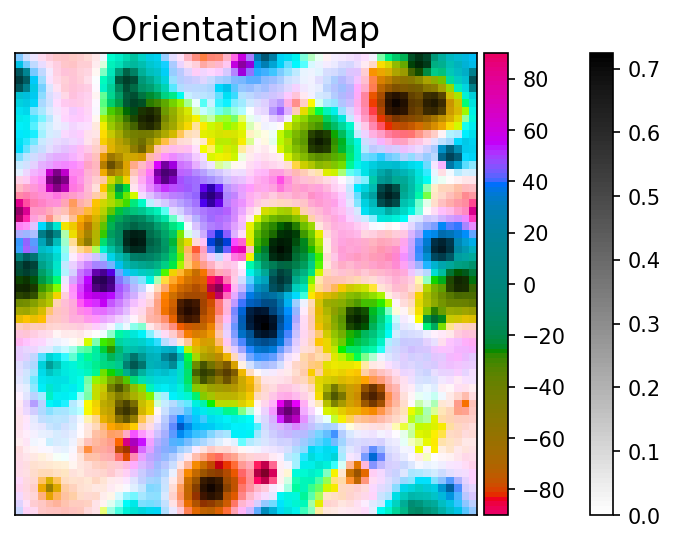

In [74]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=150)

pf.domcolbar(fig,axs,z_field,origin='lower',alim=[-90,90],rlim=[0,None],zorder=0)

axs.set_title('Orientation Map',fontsize=16)

# Compare L4 vs L2/3 OPM

## Compare maps

Text(0.5, 1.0, 'L2/3 Activity Orientation Selectivity')

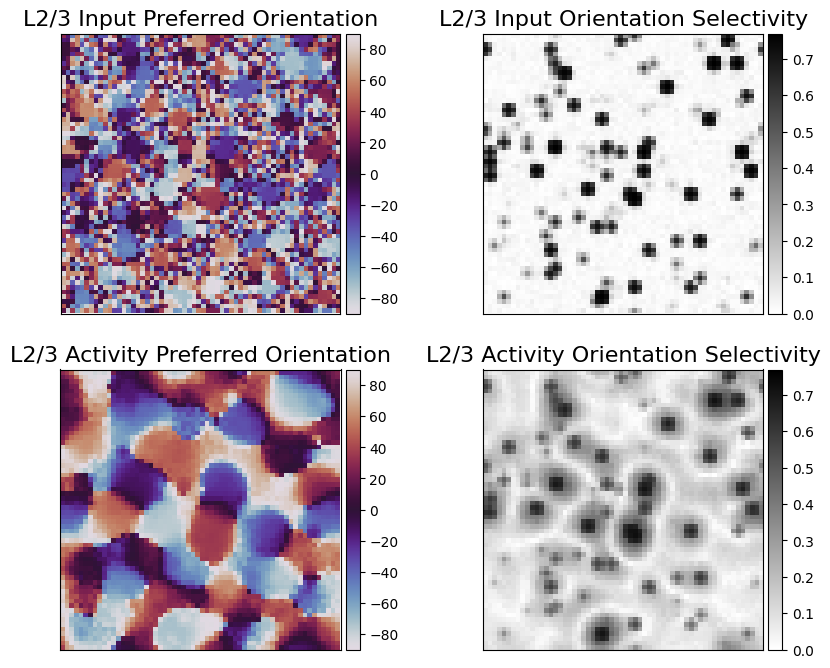

In [75]:
fig,axs = plt.subplots(2,2,figsize=(10,8))

pf.imshowbar(fig,axs[0,0],inp_pref_ori,origin='lower',cmap='twilight',vmin=-90,vmax=90)

pf.imshowbar(fig,axs[0,1],inp_ori_sel,origin='lower',cmap='binary',
             vmin=0,vmax=max(np.max(inp_ori_sel),np.max(ori_sel)))

pf.imshowbar(fig,axs[1,0],pref_ori,origin='lower',cmap='twilight',vmin=-90,vmax=90)

pf.imshowbar(fig,axs[1,1],ori_sel,origin='lower',cmap='binary',
             vmin=0,vmax=max(np.max(inp_ori_sel),np.max(ori_sel)))

axs[0,0].set_title('L2/3 Input Preferred Orientation',fontsize=16)
axs[0,1].set_title('L2/3 Input Orientation Selectivity',fontsize=16)
axs[1,0].set_title('L2/3 Activity Preferred Orientation',fontsize=16)
axs[1,1].set_title('L2/3 Activity Orientation Selectivity',fontsize=16)

In [76]:
print('L4 Avg OS =',np.mean(inp_ori_sel))
print('L2/3 Avg OS =',np.mean(ori_sel))

L4 Avg OS = 0.09926701363323885
L2/3 Avg OS = 0.185252774381452


## Look at orientation preference mismatch

In [77]:
opm_mismatch = np.abs(inp_pref_ori - pref_ori)
opm_mismatch[opm_mismatch > 90] = 180 - opm_mismatch[opm_mismatch > 90]

Text(0, 0.5, 'Count')

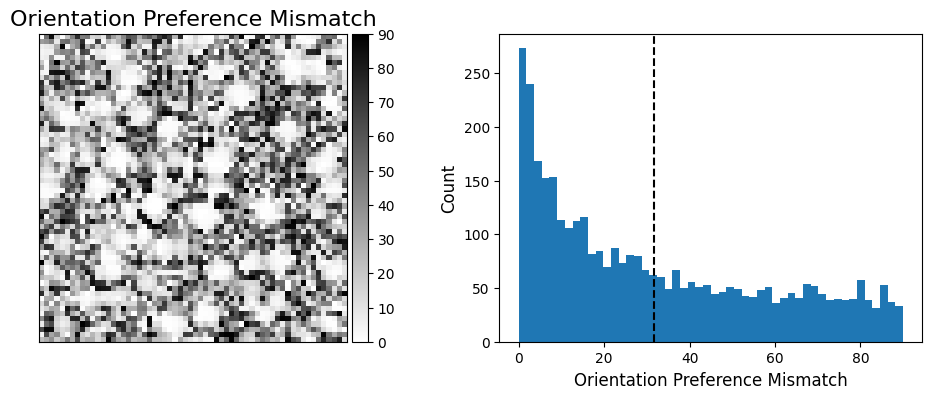

In [78]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

pf.imshowbar(fig,axs[0],opm_mismatch,
             origin='lower',cmap='binary',vmin=0,vmax=90)
axs[1].hist(opm_mismatch.flatten(),50)
axs[1].axvline(np.mean(opm_mismatch),c='k',ls='--')

axs[0].set_title('Orientation Preference Mismatch',fontsize=16)
axs[1].set_xlabel('Orientation Preference Mismatch',fontsize=12)
axs[1].set_ylabel('Count',fontsize=12)

In [79]:
np.mean(opm_mismatch)

31.657095519978505